# Strategy to compute the second output given the first output

Observing the data we have notice that
1. The outputs of the ML cup are strongly correlated.
2. One of the two output is really easy to learn ('cause is linear with some input).

With this two assumption one could try to learn the second output after the learning of the first output with various methods 

In [1]:
%matplotlib inline
project_dir = '../../'
data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')

import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
import MLP
import layer
importlib.reload(MLP)
importlib.reload(layer)
from MLP import MLP
from utils.preprocessing import split,Normalize

In [2]:

def plot_results(network):
    train_pred = network.predict(input_data)
    val_pred = network.predict(val_data)
    x = np.arange(len(network.train_MEE))

    fig = plt.figure(figsize=(13,4))

    fig.add_subplot(131)
    plt.plot(x,network.train_MEE)
    plt.plot(x,network.val_MEE,label="test")
    plt.title("Learning curve")
    plt.xlabel("Epochs")
    plt.ylabel("Squared error")
    plt.yscale("log")
    plt.legend()

    fig.add_subplot(132)
    plt.title('Residual for training data')
    plt.plot(np.arange(len(labels)),labels[:,0]-train_pred[:,0],".",label="residual0")
    plt.plot(np.arange(len(labels)),labels[:,1]-train_pred[:,1],".",label="residual1")
    plt.legend()

    fig.add_subplot(133)
    plt.title('Residual for validation data')
    plt.plot(np.arange(len(val_labels)),val_labels[:,0]-val_pred[:,0],".",label="residual0")
    plt.plot(np.arange(len(val_labels)),val_labels[:,1]-val_pred[:,1],".",label="residual1")
    plt.legend()
    plt.tight_layout()
    plt.show()
    netw.predict(input_data)


## Importing data

In [8]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
np.random.shuffle(raw_data)
other_output=raw_data[:,10]
lin_output=raw_data[:,11]
raw_data=np.delete(raw_data,10,axis=1)

#raw_normalizer=Normalize()
#raw_data=raw_normalizer.normalize(raw_data)

## Splitting the data

In [9]:

frac_test=0.15
data, test_set=split(raw_data,kind="hold_out",frac_training=1-frac_test)

frac_training=0.8
training,validation=split(data,kind="hold_out",frac_training=frac_training)

input_data=training[:,1:-2]
labels=training[:,-2:]
val_data=validation[:,1:-2]
val_labels=validation[:,-2:]

### Correlation between the outputs

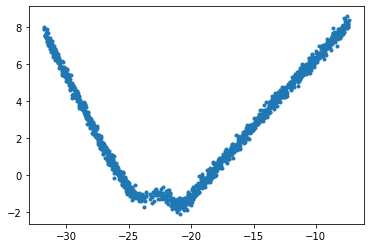

In [5]:
plt.plot(raw_data[:,10],other_output,".")
plt.show()

In [6]:
from scipy.optimize import curve_fit
def f1(x,m1,m2,b1,b2,mu,sigma,a,c,start,stop):
    return np.heaviside(start-x,0)*(m1*x+b1)+ \
        np.heaviside(x-start,0)*np.heaviside(stop-x,0)*(a*np.exp(-(x-mu)**2/(2*sigma**2))+c)+\
        np.heaviside(x-stop,0)*(m2*x+b2)


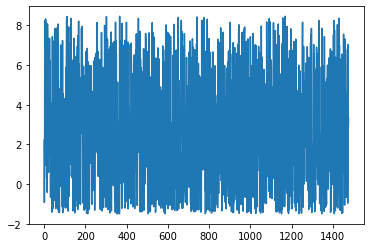

In [7]:
initial=np.array([-1.2,0.75,-30.8,14,-22.5,1,0.7,-1.6,-24.5,-20.5])
bound=np.array([1,1,20,20,1.5,2,3,1,3,3])
x = raw_data[:,10]
plt.plot(f1(x, *initial))
plt.show()

In [8]:
#popt,pcov=curve_fit(f1,raw_data[:,10],other_output,
#                    p0=initial,bounds=(initial-bound,initial+bound))

## Second fit try

Let's create the fit function step by step

### Fit with parabola

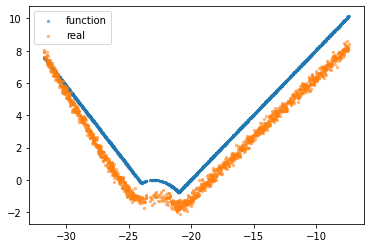

In [12]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
np.random.shuffle(raw_data)
other_output=raw_data[:,10]
lin_output=raw_data[:,11]
raw_data=np.delete(raw_data,10,axis=1)

x1 = np.copy(lin_output)
y1 = np.copy(other_output)

def parabola(x, a, b, c, stop1 = None, stop2 = None, stop = True):
    g = a * x*x + b * x + c # the parabola
    if stop: # Manual double heaviside
        g[x<stop1] = 0
        g[x>stop2] = 0
    return g

def linear(x, m, stop, a, b, c, cut_left = True):
    # Compute q in a way to create a continuos function
    q = parabola(stop,  a, b, c, stop = False) - m * stop
    y = m*x + q # the linear function
    if cut_left: y[x<stop] = 0 # Manual left heaviside
    else: y[x>stop] = 0 # Manual right heaviside
    return y

def lin_para_lin(x, a, b, c, m1, stop1, m2, stop2):
    """
    Fit function create by hand:
    - on the left a linear function with angolar coefficient m1
    - on the middle a parabola ax^2 + bx + c
    - on the right another linear function with m2
    stop1 and stop2 are the two points where you switch from 
    linear1->parabola and parabola->linear 2 (with continuity).
    NOTE: the intercept q of the linear function are fixed for the 
          continuity.
    """
    return linear(x, m1, stop1, a, b, c, cut_left = False) +\
           parabola(x, a, b, c, stop1, stop2) +\
           linear(x, m2, stop2,  a, b, c, cut_left = True)

# Parabola parameters in order to catch the maximum [ wikipedia formula :( ] 
c = -100
x_v = -23
y_v = 0

# Linear parameters: m and stop
lin_params1 = (-1, -24)
lin_params2 = (0.8, -21)


a = (y_v + c)/(x_v**2)
b = -2 * a * x_v 
parabola_params = (a, b, c)

plt.scatter(x1, lin_para_lin(x1, *parabola_params, *lin_params1, *lin_params2), 
            s = 5, label ='function', alpha = 0.5)
plt.scatter(x1, y1, s = 5, label ='real', alpha = 0.5)
plt.legend()
plt.show()

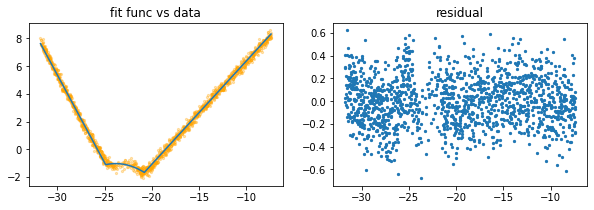

RMS = 8.204114079624123 (root sum of squared residual)


In [13]:
params = (*parabola_params, *lin_params1, *lin_params2)
popt,pcov=curve_fit(lin_para_lin,x1, y1, p0=params)
parametri = popt
xx = np.linspace(np.min(x), np.max(x), 1000)
fig, axs = plt.subplots(1, 2, figsize = (10, 3))
axs[0].plot(xx,lin_para_lin(xx,*popt))
axs[0].scatter(x1, y1, s = 5, label ='real', alpha = 0.3, c='orange')
axs[0].set_title('fit func vs data')
axs[1].scatter(x1, y1-lin_para_lin(x1,*popt), s = 5)
axs[1].set_title('residual')
plt.show()
RMS = np.sqrt(np.sum((y1-lin_para_lin(x1,*popt))**2))
print(f'RMS = {RMS} (root sum of squared residual)')

In the same way one could do a fit with a gaussian...

/tmp/ipykernel_10909/3548346466.py:12: RuntimeWarning: invalid value encountered in sqrt
  return A*(1/np.sqrt(2*np.pi*sigma))*np.exp(-(x-mu)**2/(2*sigma**2))


normalization 2.160745107111347 mean -0.00386859365129922 variance 0.21724048433684864


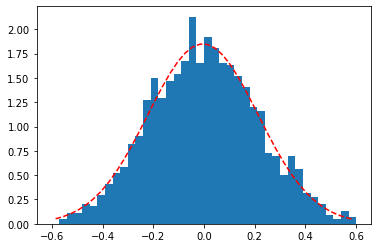

In [33]:
#trying to fit the residual with ipothesyis test: gaussian with mean = 0 and variance = sigma


residual = (y1-lin_para_lin(x1,*popt))
n_bin = 40 ; l = 0.6
yy, bin , aa = plt.hist(residual,bins = n_bin, range = (-l,l),density = True)


bin = bin[1:] - l/n_bin

def gauss(x,A,mu,sigma):
    return A*(1/np.sqrt(2*np.pi*sigma))*np.exp(-(x-mu)**2/(2*sigma**2))

p0 = (2,1,0.3)
param, covm = curve_fit(gauss,bin,yy, p0)
plt.plot(bin,gauss(bin,*param), color = 'red' , linestyle = '--')

print('normalization',param[0],'mean',param[1],'variance',param[2])

## Other methods: multiple fit

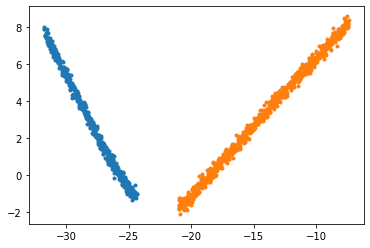

In [ ]:
x=np.linspace(-30,-10,100)
mask=lin_output<-24.3
mask2=lin_output>-21.
plt.plot(lin_output[mask],other_output[mask],".",
         lin_output[mask2],other_output[mask2],".")

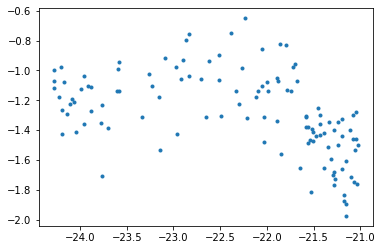

In [ ]:
mask3=np.all([lin_output<-21,lin_output>-24.3],axis=0)
plt.plot(lin_output[mask3],other_output[mask3],".")

In [ ]:
def linear(x,a,b):
    return a*x+b
def gaussian(x,mu,sigma,a,c):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))+c
def parabola(x,a,b,c):
    return a*x**2+b*x+c

popt1,pcov1=curve_fit(linear,lin_output[mask],other_output[mask])
popt2,pcov2=curve_fit(linear,lin_output[mask2],other_output[mask2])
popt3,pcov3=curve_fit(parabola,lin_output[mask3],other_output[mask3])

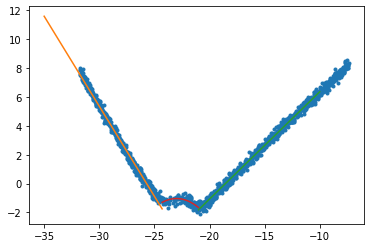

In [ ]:
#-21,-24.3
x1=np.linspace(-35,-24.3,100)
x3=np.linspace(-24.3,-21,100)
x2=np.linspace(-21,-10,100)
plt.plot(lin_output,other_output,".")
plt.plot(x1,linear(x1,*popt1),"-",label="linear")
plt.plot(x2,linear(x2,*popt2),"-",label="linear")
plt.plot(x3,parabola(x3,*popt3),"-",label="gaussian")


## Use a neural network to solve the task

Can ours NN solve the nonlinear task?

In [12]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
np.random.shuffle(raw_data)

other_output=raw_data[:,10]
lin_output=raw_data[:,11]

In [13]:
n_data = len(lin_output)
data = lin_output.reshape((n_data, 1))
labels = other_output.reshape((n_data, 1))

In [67]:
structure=[50,50,np.shape(labels)[1]]
act_func=["relu","relu","linear"]
start=[1e-1]*4

netw = MLP(structure, func=act_func,
           starting_points=start)

In [88]:
eta = 0.0001
N_epoch = 10000
lamb=0
batch_size =-1 #-1 for batch gradient descent
alpha=0.3
nesterov=False

netw.train(data, labels, data, labels,
           epoch = N_epoch,
           batch_size=batch_size,
           eta =eta, lamb = lamb,alpha=alpha,
           nesterov=nesterov)

KeyboardInterrupt: 

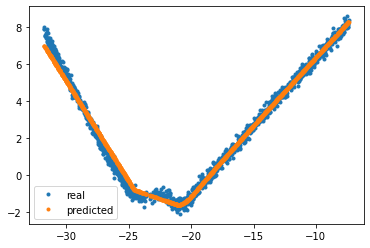

In [89]:
plt.plot(data, labels, '.', label = 'real')
plt.plot(data, netw.predict(data), '.', label = 'predicted')

plt.legend()
plt.show()

# NOPE

In [18]:
from keras.layers import Input, Dense
from keras.models import Model
inp=Input(shape=(1,))
hidden=Dense(50,activation='relu')(inp)
hidden=Dense(50,activation='relu')(hidden)
hidden=Dense(30,activation='relu')(hidden)
output=Dense(1,activation='linear')(hidden)

model=Model(inputs=inp,outputs=output)
model.compile(optimizer='rmsprop',loss='mse')
model.fit(data,labels,epochs=300,verbose=1)

Epoch 1/300
47/47 [==============================] - 2s 12ms/step - loss: 16.1390
Epoch 2/300
47/47 [==============================] - 1s 12ms/step - loss: 15.9210
Epoch 3/300
47/47 [==============================] - 0s 8ms/step - loss: 15.6971
Epoch 4/300
47/47 [==============================] - 1s 13ms/step - loss: 15.4808
Epoch 5/300
47/47 [==============================] - 1s 13ms/step - loss: 15.2670
Epoch 6/300
47/47 [==============================] - 0s 7ms/step - loss: 15.0548
Epoch 7/300
47/47 [==============================] - 1s 12ms/step - loss: 14.8536
Epoch 8/300
47/47 [==============================] - 1s 30ms/step - loss: 14.6529
Epoch 9/300
47/47 [==============================] - 1s 24ms/step - loss: 14.4652
Epoch 10/300
47/47 [==============================] - 1s 17ms/step - loss: 14.2816
Epoch 11/300
47/47 [==============================] - 1s 13ms/step - loss: 14.1057
Epoch 12/300
47/47 [==============================] - 0s 10ms/step - loss: 13.9363
Epoch 13/300
47

KeyboardInterrupt: 

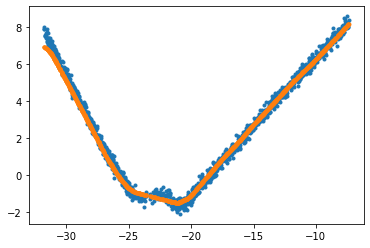

In [17]:
plt.plot(data,labels,".")
plt.plot(data,model.predict(data),".")

